In [1]:
from src.data import load_data
from src.models import util_model
from src.data import util
from pathlib import Path

In [2]:
image_name = "trans020" 
front_image_name = image_name + "-1"
back_image_name = image_name + "-2"
front_image_path = "data/raw/front"
back_image_path = "data/raw/back"
front_image = load_data.read_image(front_image_path, front_image_name)
back_image = load_data.read_image(back_image_path, back_image_name)

In [3]:
front_section_dict = util_model.detect_section(front_image, util_model.front_model)
pf_sections = util.pre_process(front_section_dict)
front_text_dict = util_model.images_to_texts(pf_sections)
courses_df = util.make_course(front_text_dict)
post_courses_df = util.post_process(courses_df, pf_sections)
error_df = util.get_error(post_courses_df).reset_index(drop=True)
error_df


0: 640x480 3 sections, 932.4ms
Speed: 2.7ms preprocess, 932.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


,ocr,numeric,section,id,name,unit,grade


In [4]:
# front_text_dict[2].split("\n")

In [5]:
back_section_dict = util_model.detect_section(back_image, util_model.back_model)
pb_sections = util.pre_process(back_section_dict)
back_text_dict = util_model.images_to_texts(pb_sections)


0: 640x480 1 section, 854.7ms
Speed: 2.6ms preprocess, 854.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


In [6]:
util.get_GPA(back_text_dict[0])

0                            ภาษาไทย          5.0 3.60
1                         คณิตศาสตร์         16.5 3.87
2                 วิทยาศาสตร์และเทคโนโลยี    30.0 3.49
3                สังคมศึกษา ศาสนา และวัฒนธรรม 6.5 3.65
4                     สุขศึกษาและพลศึกษา      2.5 4.00
5                            ศิลปะ            3.5 4.00
6                         การงานอาชีพ         2.0 3.75
7    .ภาษาต่างประเทศ                           10.0...
8        การศึกษาค้นคว้าด้วยตนเอง (!5)        1.5 4.00
9              ผลการเรียนเฉลี่ยตลอดหลักสูตร  77.5 3.65
dtype: object

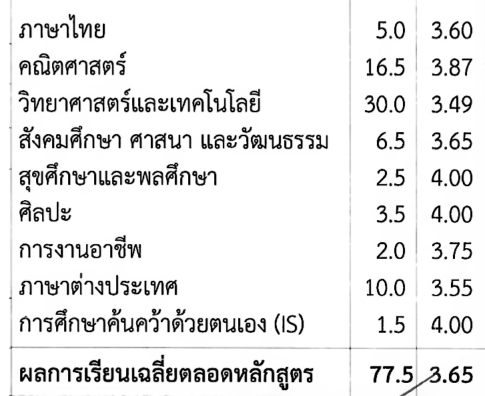

In [7]:
pb_sections[0]

In [8]:
front_edf = post_courses_df[["id", "name", "unit", "grade"]]
front_edf.isnull().sum()

id       0
name     0
unit     0
grade    0
dtype: int64

In [10]:
load_data.export_df_to_csv("data/out/csv", front_image_name, front_edf)
load_data.csv_to_json("data/out/json", "data/out/csv", front_image_name)

In [11]:
from PIL import ImageDraw, ImageFont
import pandas as pd

In [12]:
def add_alphabet_to_image(image, bounding_box, alphabet, font:str):
    # Open the original image
    draw = ImageDraw.Draw(image)

    # Calculate the width for the whitespace (assuming it is 1% of the image width)
    white_space_width = int(image.width * 0.01)

    # Load a font
    font_path = Path('data/font')/font/f"{font}.ttf"
    
    df = pd.DataFrame(bounding_box)
    font_size = df.height.median()*3
    # Extract the bounding box coordinates
    for i in range(len(bounding_box)):
        left, top, width, height, textt = bounding_box[i].values()

        # Set the font size to fit the bounding box
        font = ImageFont.truetype(font_path, font_size)
        
        # Calculate position for the alphabet
        text_x = white_space_width // 2
        text_y = top-height*(3/2)


        # Draw the alphabet on the image
        draw.text((text_x, text_y), alphabet, font=font, fill="black")
    return image


In [13]:
bb = util.get_lines_pos(processed_sections[0])

NameError: name 'processed_sections' is not defined

In [ ]:
bb

[{'left': 122, 'top': 13, 'width': 44, 'height': 17, 'text': '2565'},
 {'left': 28, 'top': 36, 'width': 50, 'height': 15, 'text': '33101'},
 {'left': 27, 'top': 65, 'width': 50, 'height': 15, 'text': '33101'},
 {'left': 27, 'top': 94, 'width': 51, 'height': 15, 'text': '33102'},
 {'left': 28, 'top': 123, 'width': 52, 'height': 15, 'text': '33103'},
 {'left': 27, 'top': 153, 'width': 49, 'height': 15, 'text': '33101'},
 {'left': 26, 'top': 182, 'width': 50, 'height': 15, 'text': '33101'},
 {'left': 27, 'top': 211, 'width': 49, 'height': 15, 'text': '33201'},
 {'left': 26, 'top': 240, 'width': 52, 'height': 16, 'text': '33203'},
 {'left': 25, 'top': 270, 'width': 49, 'height': 15, 'text': '30291'},
 {'left': 24, 'top': 299, 'width': 50, 'height': 15, 'text': '33201'},
 {'left': 24, 'top': 328, 'width': 50, 'height': 15, 'text': '33221'},
 {'left': 24, 'top': 357, 'width': 50, 'height': 15, 'text': '33241'},
 {'left': 25, 'top': 386, 'width': 52, 'height': 15, 'text': '30206'},
 {'left': 

In [ ]:
bb

[{'left': 122, 'top': 13, 'width': 44, 'height': 17, 'text': '2565'},
 {'left': 28, 'top': 36, 'width': 50, 'height': 15, 'text': '33101'},
 {'left': 27, 'top': 65, 'width': 50, 'height': 15, 'text': '33101'},
 {'left': 27, 'top': 94, 'width': 51, 'height': 15, 'text': '33102'},
 {'left': 28, 'top': 123, 'width': 52, 'height': 15, 'text': '33103'},
 {'left': 27, 'top': 153, 'width': 49, 'height': 15, 'text': '33101'},
 {'left': 26, 'top': 182, 'width': 50, 'height': 15, 'text': '33101'},
 {'left': 27, 'top': 211, 'width': 49, 'height': 15, 'text': '33201'},
 {'left': 26, 'top': 240, 'width': 52, 'height': 16, 'text': '33203'},
 {'left': 25, 'top': 270, 'width': 49, 'height': 15, 'text': '30291'},
 {'left': 24, 'top': 299, 'width': 50, 'height': 15, 'text': '33201'},
 {'left': 24, 'top': 328, 'width': 50, 'height': 15, 'text': '33221'},
 {'left': 24, 'top': 357, 'width': 50, 'height': 15, 'text': '33241'},
 {'left': 25, 'top': 386, 'width': 52, 'height': 15, 'text': '30206'},
 {'left': 

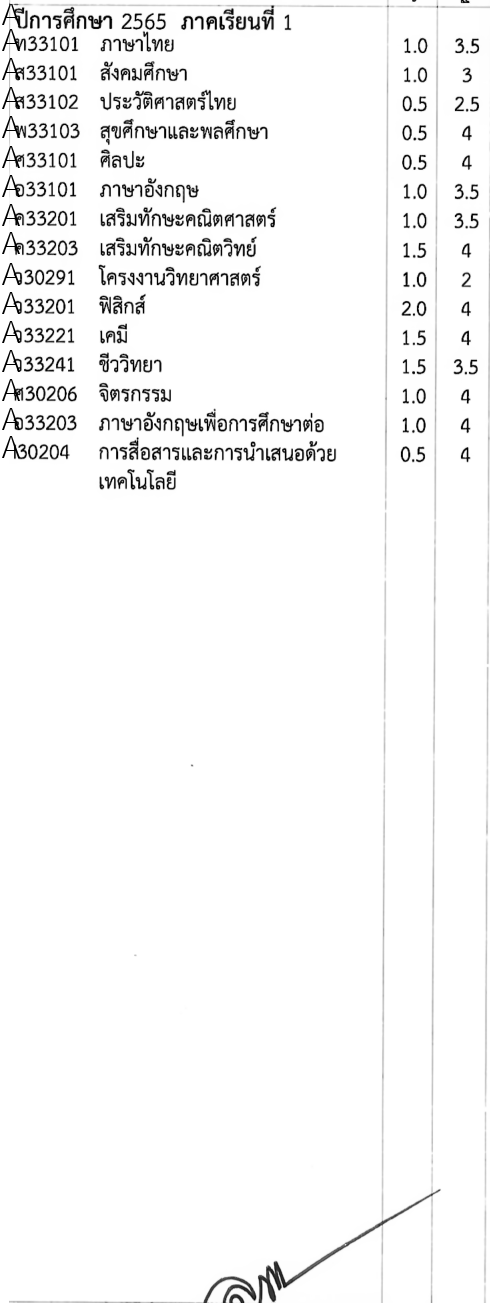

In [ ]:
add_alphabet_to_image(processed_sections[0], bb, 'A', 'THSarabunNew')